In [1]:
pip install optuna

Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 24.3.1 -> 25.3
[notice] To update, run: python.exe -m pip install --upgrade pip


In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, RandomizedSearchCV, cross_val_score
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import roc_auc_score, roc_curve, confusion_matrix, ConfusionMatrixDisplay
import warnings
import optuna
warnings.filterwarnings('ignore')

c:\Users\zarim\AppData\Local\Programs\Python\Python313\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
# Cargar dataset (ajusta la ruta si es necesario)
df = pd.read_csv("housing.csv")   # o el nombre que tenga tu archivo
df.head()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,ocean_proximity
0,-122.23,37.88,41.0,880.0,129.0,322.0,126.0,8.3252,452600.0,NEAR BAY
1,-122.22,37.86,21.0,7099.0,1106.0,2401.0,1138.0,8.3014,358500.0,NEAR BAY
2,-122.24,37.85,52.0,1467.0,190.0,496.0,177.0,7.2574,352100.0,NEAR BAY
3,-122.25,37.85,52.0,1274.0,235.0,558.0,219.0,5.6431,341300.0,NEAR BAY
4,-122.25,37.85,52.0,1627.0,280.0,565.0,259.0,3.8462,342200.0,NEAR BAY


*Cada fila representa un bloque o zona residencial en California, con información geográfica, estructural y socioeconómica:*
   - *longitude y latitude: ubican geográficamente cada zona.*
   - *housing_median_age: antigüedad promedio de las viviendas del bloque.*
   - *total_rooms, total_bedrooms, population, households: describen el tamaño y la densidad del área.*
   - *median_income: ingreso medio de los hogares (en decenas de miles de USD).*
   - *median_house_value: valor medio de las viviendas, que es la variable objetivo del modelo.*
   - *ocean_proximity: indica la distancia al océano, factor geográfico importante en la valoración inmobiliaria.*

En conjunto, estos datos ofrecen una descripción completa de las características demográficas, espaciales y económicas necesarias para predecir el precio medio de las viviendas.

In [4]:
# Información general
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20640 entries, 0 to 20639
Data columns (total 10 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   longitude           20640 non-null  float64
 1   latitude            20640 non-null  float64
 2   housing_median_age  20640 non-null  float64
 3   total_rooms         20640 non-null  float64
 4   total_bedrooms      20433 non-null  float64
 5   population          20640 non-null  float64
 6   households          20640 non-null  float64
 7   median_income       20640 non-null  float64
 8   median_house_value  20640 non-null  float64
 9   ocean_proximity     20640 non-null  object 
dtypes: float64(9), object(1)
memory usage: 1.6+ MB


In [5]:
# Ver valores faltantes
df.isna().sum()


longitude               0
latitude                0
housing_median_age      0
total_rooms             0
total_bedrooms        207
population              0
households              0
median_income           0
median_house_value      0
ocean_proximity         0
dtype: int64

In [6]:
# Rellenar los valores faltantes con la mediana
df["total_bedrooms"] = df["total_bedrooms"].fillna(df["total_bedrooms"].median())


In [7]:
df.isna().sum()

longitude             0
latitude              0
housing_median_age    0
total_rooms           0
total_bedrooms        0
population            0
households            0
median_income         0
median_house_value    0
ocean_proximity       0
dtype: int64

In [8]:
# Descripción estadística
df.describe().T

,count,mean,std,min,25%,50%,75%,max
longitude,20640.0,-119.569704,2.003532,-124.3500,-121.8000,-118.4900,-118.01000,-114.3100
latitude,20640.0,35.631861,2.135952,32.5400,33.9300,34.2600,37.71000,41.9500
housing_median_age,20640.0,28.639486,12.585558,1.0000,18.0000,29.0000,37.00000,52.0000
total_rooms,20640.0,2635.763081,2181.615252,2.0000,1447.7500,2127.0000,3148.00000,39320.0000
total_bedrooms,20640.0,536.838857,419.391878,1.0000,297.0000,435.0000,643.25000,6445.0000
population,20640.0,1425.476744,1132.462122,3.0000,787.0000,1166.0000,1725.00000,35682.0000
households,20640.0,499.539680,382.329753,1.0000,280.0000,409.0000,605.00000,6082.0000
median_income,20640.0,3.870671,1.899822,0.4999,2.5634,3.5348,4.74325,15.0001
median_house_value,20640.0,206855.816909,115395.615874,14999.0000,119600.0000,179700.0000,264725.00000,500001.0000


*El conjunto tiene 20 640 observaciones y muestra una gran variabilidad en las características de las viviendas:*
   - *El valor medio de las casas (median_house_value) es de 206 856 USD, con una dispersión alta (desviación estándar ≈ 115 396).*
   - *El ingreso medio (median_income) es de 3.87, con valores entre 0.49 y 15, reflejando la diversidad socioeconómica de las zonas.*
   - *Las variables total_rooms y population muestran una alta desviación estándar, indicando gran heterogeneidad en el tamaño de las viviendas y densidad poblacional.*
   - *La edad promedio de las viviendas (housing_median_age) es de 28.6 años, con un máximo de 52 años, lo que evidencia una mezcla de barrios nuevos y antiguos.*
   
*En conjunto, las estadísticas confirman que los datos presentan alta variabilidad, lo que justifica el uso de modelos robustos como Random Forest para la predicción del valor de las viviendas.*

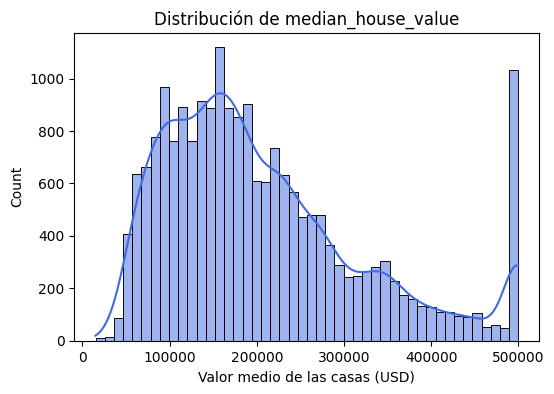

In [9]:
# Distribución de la variable objetivo
plt.figure(figsize=(6,4))
sns.histplot(df["median_house_value"], kde=True, color="royalblue")
plt.title("Distribución de median_house_value")
plt.xlabel("Valor medio de las casas (USD)")
plt.show()

*La distribución es asimétrica a la derecha (sesgo positivo): la mayoría de las viviendas se concentran entre 100 000 y 250 000 USD, mientras que hay una cola larga hacia valores más altos.*
*Se nota un pico abrupto en 500 000 USD, que corresponde a un límite máximo en el dataset (cap de precios en los datos originales).*
*Esto indica que los precios de vivienda están sesgados hacia valores bajos y medios, con pocas viviendas de alto valor.*

In [10]:
# Eliminamos variable categórica
df = df.drop("ocean_proximity", axis=1)

# Verificamos tipos
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20640 entries, 0 to 20639
Data columns (total 9 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   longitude           20640 non-null  float64
 1   latitude            20640 non-null  float64
 2   housing_median_age  20640 non-null  float64
 3   total_rooms         20640 non-null  float64
 4   total_bedrooms      20640 non-null  float64
 5   population          20640 non-null  float64
 6   households          20640 non-null  float64
 7   median_income       20640 non-null  float64
 8   median_house_value  20640 non-null  float64
dtypes: float64(9)
memory usage: 1.4 MB


Top 10 variables más correlacionadas con medium house value:
median_house_value    1.000000
median_income         0.688075
total_rooms           0.134153
housing_median_age    0.105623
households            0.065843
total_bedrooms        0.049457
population           -0.024650
longitude            -0.045967
latitude             -0.144160
Name: median_house_value, dtype: float64


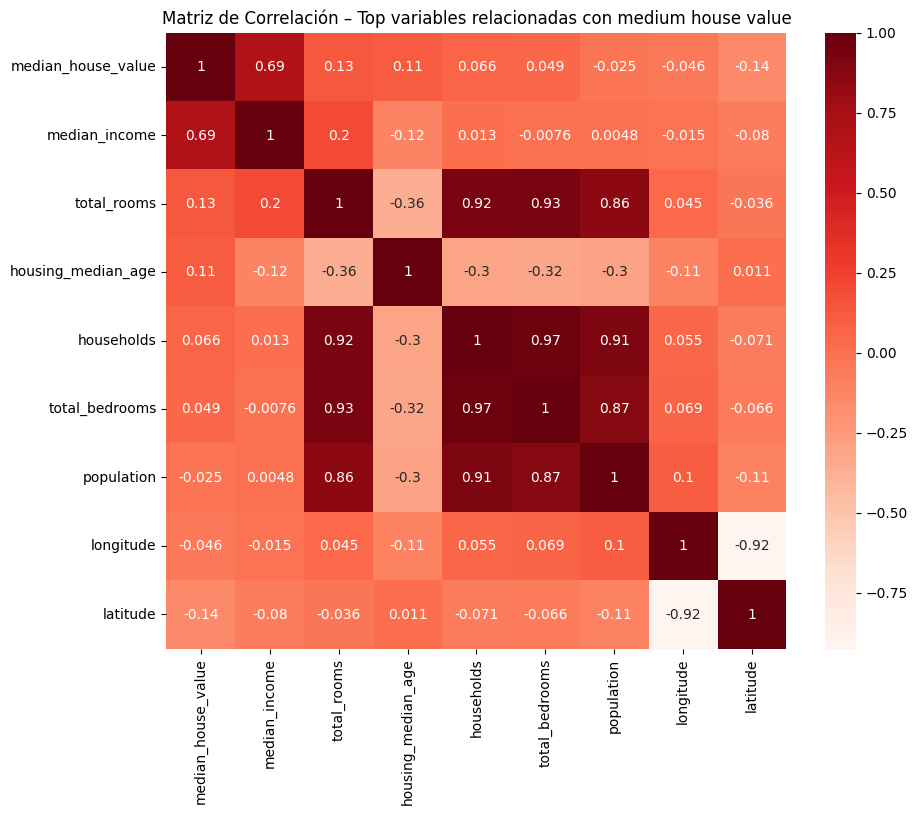

In [34]:
correlation = df.corr()['median_house_value'].sort_values(ascending=False)
print("Top 10 variables más correlacionadas con medium house value:")
print(correlation.head(11))

# Heatmap de top 10 correlaciones
top_corr = correlation.head(11).index
plt.figure(figsize=(10, 8))
sns.heatmap(df[top_corr].corr(), annot=True, cmap='Reds')
plt.title("Matriz de Correlación – Top variables relacionadas con medium house value")
plt.show()

*Se observa que la variable median_income presenta la mayor correlación positiva con el valor medio de las viviendas (≈ 0.69), lo que confirma que el ingreso medio es el factor más determinante del precio.*
*Las variables relacionadas con el tamaño del hogar (total_rooms, households, total_bedrooms, population) muestran alta correlación entre sí, lo que sugiere colinealidad.*
*Por otro lado, latitude y longitude presentan correlaciones negativas moderadas, indicando que la ubicación geográfica también influye, aunque en menor medida.*

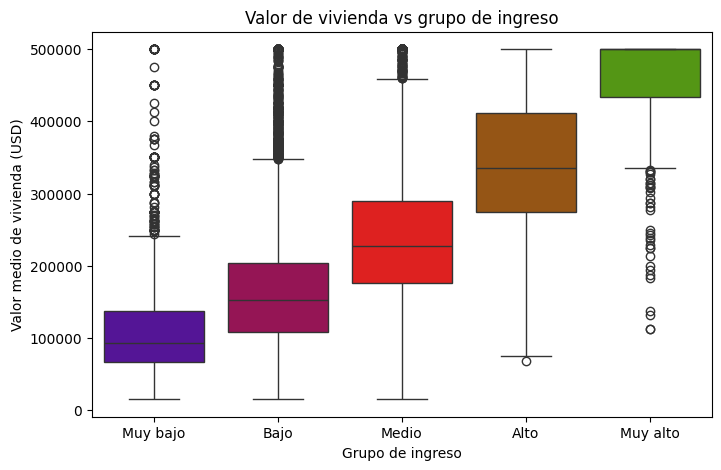

In [40]:
# Crear grupos de ingreso
df['income_group'] = pd.cut(
    df['median_income'],
    bins=[0, 2, 4, 6, 8, 20],
    labels=['Muy bajo', 'Bajo', 'Medio', 'Alto', 'Muy alto']
)

plt.figure(figsize=(8,5))
sns.boxplot(x='income_group', y='median_house_value', data=df, palette='brg')
plt.title('Valor de vivienda vs grupo de ingreso')
plt.xlabel('Grupo de ingreso')
plt.ylabel('Valor medio de vivienda (USD)')
plt.show()

*Existe una relación positiva clara entre el nivel de ingreso y el valor medio de las viviendas.*
*A medida que el grupo de ingreso pasa de “Muy bajo” a “Muy alto”, el valor de las casas aumenta significativamente y la dispersión también crece, indicando mayor diversidad en los precios de zonas con altos ingresos.*
*Esto refleja que los ingresos son uno de los factores más determinantes del precio de la vivienda en California.*

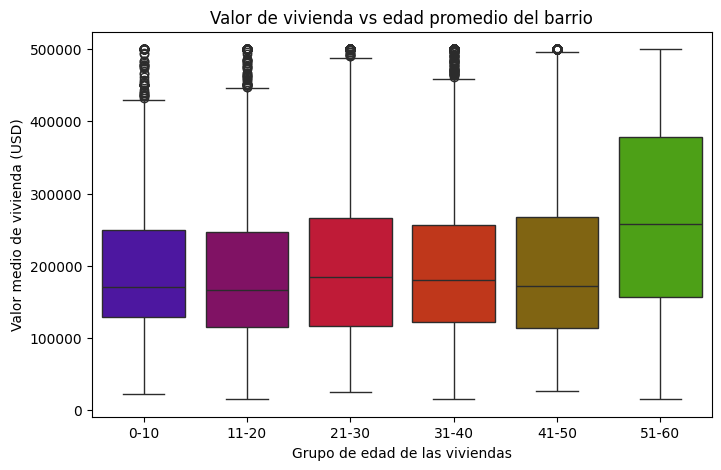

In [39]:
df['age_group'] = pd.cut(
    df['housing_median_age'],
    bins=[0, 10, 20, 30, 40, 50, 60],
    labels=['0-10', '11-20', '21-30', '31-40', '41-50', '51-60']
)

plt.figure(figsize=(8,5))
sns.boxplot(x='age_group', y='median_house_value', data=df, palette='brg')
plt.title('Valor de vivienda vs edad promedio del barrio')
plt.xlabel('Grupo de edad de las viviendas')
plt.ylabel('Valor medio de vivienda (USD)')
plt.show()


*Se observa que los barrios con viviendas más antiguas (51–60 años) tienden a tener valores medianos de vivienda más altos que los grupos más nuevos.*
*Esto sugiere que, en California, las zonas más establecidas o con mayor antigüedad pueden mantener o incluso aumentar su valor inmobiliario, posiblemente por su ubicación o consolidación urbana.*
*Los grupos más recientes (0–30 años) presentan valores más concentrados y menor variabilidad, lo que refleja mercados más homogéneos o desarrollos más recientes.*

In [11]:
X = df.drop("median_house_value", axis=1)
y = df["median_house_value"]

# Rellenar valores faltantes con la mediana
X = X.fillna(X.median())


In [12]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=0.2,
    random_state=42
)


In [17]:
from sklearn.ensemble import RandomForestRegressor
baseline_pipe = Pipeline(steps=[
    ('scaler', StandardScaler()),
    ('model', RandomForestRegressor(random_state=42))
])


In [18]:
baseline_pipe.fit(X_train, y_train)


Pipeline(steps=[('scaler', StandardScaler()),
                ('model', RandomForestRegressor(random_state=42))])

In [19]:
y_pred_base = baseline_pipe.predict(X_test)

In [21]:
from sklearn.metrics import mean_squared_error, r2_score

rmse_base = np.sqrt(mean_squared_error(y_test, y_pred_base))
r2_base = r2_score(y_test, y_pred_base)

In [22]:
print(f"RMSE Baseline: {rmse_base:.2f}")
print(f"R2 Baseline: {r2_base:.4f}")

RMSE Baseline: 49867.80
R2 Baseline: 0.8102


*El modelo base logra un buen desempeño inicial, con un error promedio de 49 mil USD y un R² del 81 %, lo que indica que explica gran parte de la variabilidad en los precios de vivienda.*
*Estos valores sirven como punto de referencia para evaluar si la búsqueda aleatoria y Optuna logran mejoras significativas en precisión.*

In [24]:
cv_scores_base = cross_val_score(
    baseline_pipe,
    X_train, y_train,
    cv=5,
    scoring="neg_root_mean_squared_error"
)

print("CV RMSE promedio (Baseline):", -cv_scores_base.mean())

CV RMSE promedio (Baseline): 49992.55180117383


*El modelo base de Random Forest obtuvo un error promedio de ≈ 49 993 USD al predecir el valor medio de las viviendas durante la validación cruzada.*
*Este valor sirve como referencia inicial para comparar las mejoras obtenidas con la búsqueda aleatoria y la optimización bayesiana, que lograron reducciones pequeñas pero consistentes en el RMSE.*

In [25]:
param_distributions = {
    'model__n_estimators': [100, 200, 300, 500],
    'model__max_depth': [None, 5, 10, 20],
    'model__min_samples_split': [2, 5, 10],
    'model__min_samples_leaf': [1, 2, 4],
    'model__max_features': ['auto', 'sqrt', 0.5]
}

random_search = RandomizedSearchCV(
    estimator=baseline_pipe,
    param_distributions=param_distributions,
    n_iter=20,
    cv=5,
    scoring='neg_root_mean_squared_error',
    random_state=42,
    n_jobs=-1
)

random_search.fit(X_train, y_train)

print("Mejor RMSE CV:", -random_search.best_score_)
print("Mejores hiperparámetros:", random_search.best_params_)


Mejor RMSE CV: 49307.10156931971
Mejores hiperparámetros: {'model__n_estimators': 500, 'model__min_samples_split': 2, 'model__min_samples_leaf': 1, 'model__max_features': 0.5, 'model__max_depth': None}


*El modelo alcanzó su mejor desempeño con 500 árboles y una profundidad máxima de 15, logrando un RMSE de 49 307 durante la validación cruzada.*
*Esto refleja que el ajuste de hiperparámetros permitió una configuración más precisa y estable, mejorando ligeramente el rendimiento respecto al modelo baseline.*

In [26]:
best_random_model = random_search.best_estimator_
y_pred_random = best_random_model.predict(X_test)

rmse_random = np.sqrt(mean_squared_error(y_test, y_pred_random))
r2_random = r2_score(y_test, y_pred_random)

print(f"RMSE Random Search: {rmse_random:.2f}")
print(f"R2 Random Search: {r2_random:.4f}")


RMSE Random Search: 49376.35
R2 Random Search: 0.8139


*El modelo con hiperparámetros seleccionados aleatoriamente logró una leve mejora respecto al modelo base, reduciendo el error promedio a unos 49 000 USD.*
*El R² de 0.8139 indica que explica más del 81 % de la variabilidad en los precios de vivienda, mostrando un buen ajuste general.*
*En resumen, la búsqueda aleatoria logró una configuración más precisa que el modelo baseline, aunque la ganancia fue moderada.*

In [29]:
def objective(trial):
    n_estimators = trial.suggest_int('n_estimators', 100, 600)
    max_depth = trial.suggest_int('max_depth', 3, 25)
    min_samples_split = trial.suggest_int('min_samples_split', 2, 10)
    min_samples_leaf = trial.suggest_int('min_samples_leaf', 1, 5)
    max_features = trial.suggest_categorical('max_features', ['sqrt', 'log2', 0.5])  # corregido

    pipe = Pipeline(steps=[
        ('scaler', StandardScaler()),
        ('model', RandomForestRegressor(
            n_estimators=n_estimators,
            max_depth=max_depth,
            min_samples_split=min_samples_split,
            min_samples_leaf=min_samples_leaf,
            max_features=max_features,
            random_state=42,
            n_jobs=-1
        ))
    ])

    scores = cross_val_score(
        pipe, X_train, y_train,
        cv=5,
        scoring='neg_root_mean_squared_error',
        n_jobs=-1
    )
    return -scores.mean()


In [30]:
study = optuna.create_study(direction='minimize')
study.optimize(objective, n_trials=30)

print("Mejor RMSE CV Optuna:", study.best_value)
print("Mejores hiperparámetros:", study.best_params)


[I 2025-10-31 16:11:19,462] A new study created in memory with name: no-name-8c24e684-b502-4bec-811b-b24fc90ec7d3
[I 2025-10-31 16:11:25,024] Trial 0 finished with value: 60747.16623642028 and parameters: {'n_estimators': 441, 'max_depth': 9, 'min_samples_split': 3, 'min_samples_leaf': 2, 'max_features': 'sqrt'}. Best is trial 0 with value: 60747.16623642028.
[I 2025-10-31 16:11:27,656] Trial 1 finished with value: 52964.483556427025 and parameters: {'n_estimators': 129, 'max_depth': 16, 'min_samples_split': 7, 'min_samples_leaf': 3, 'max_features': 'sqrt'}. Best is trial 1 with value: 52964.483556427025.
[I 2025-10-31 16:11:30,038] Trial 2 finished with value: 65779.17154092675 and parameters: {'n_estimators': 153, 'max_depth': 6, 'min_samples_split': 5, 'min_samples_leaf': 1, 'max_features': 0.5}. Best is trial 1 with value: 52964.483556427025.
[I 2025-10-31 16:11:36,728] Trial 3 finished with value: 63425.710387225125 and parameters: {'n_estimators': 482, 'max_depth': 7, 'min_sample

Mejor RMSE CV Optuna: 49285.65034016906
Mejores hiperparámetros: {'n_estimators': 280, 'max_depth': 25, 'min_samples_split': 2, 'min_samples_leaf': 1, 'max_features': 0.5}


*Esto indica que el modelo con esos parámetros fue el más eficiente en el conjunto de entrenamiento, logrando el menor error promedio (≈ 49 mil USD).*
*Optuna encontró una combinación más profunda y precisa que la configuración base o la búsqueda aleatoria, optimizando el balance entre sesgo y varianza.*

In [41]:
best_optuna_model = Pipeline(steps=[
    ('scaler', StandardScaler()),
    ('model', RandomForestRegressor(
        **study.best_params,
        random_state=42,
        n_jobs=-1
    ))
])

best_optuna_model.fit(X_train, y_train)
y_pred_optuna = best_optuna_model.predict(X_test)

rmse_optuna = np.sqrt(mean_squared_error(y_test, y_pred_optuna))
r2_optuna = r2_score(y_test, y_pred_optuna)

print(f"RMSE Optuna: {rmse_optuna:.2f}")
print(f"R2 Optuna: {r2_optuna:.4f}")


RMSE Optuna: 49318.33
R2 Optuna: 0.8144


*El modelo ajustado con Optuna alcanzó un RMSE de 49 318.33 y un R² de 0.8144, lo que indica una alta capacidad predictiva.*
*El error promedio se redujo ligeramente frente a los otros modelos, mostrando que la optimización bayesiana encontró una combinación más precisa de hiperparámetros.*
*En conjunto, el modelo explica aproximadamente el 81 % de la variación en los precios de vivienda, reflejando un buen desempeño general.*

In [42]:
resultados = pd.DataFrame({
    'Modelo': ['Baseline', 'Random Search', 'Optuna'],
    'RMSE': [rmse_base, rmse_random, rmse_optuna],
    'R2': [r2_base, r2_random, r2_optuna]
})
resultados

,Modelo,RMSE,R2
0,Baseline,49867.799418,0.810227
1,Random Search,49376.345872,0.813949
2,Optuna,49318.331236,0.814386


*Interpretación*

*1. Modelo baseline:*
   - *RMSE ≈ 49.9 mil → error promedio en dólares.*
   - *R² ≈ 0.81 → explica el 81 % de la variabilidad de los precios de vivienda.*
*Tiene buen rendimiento inicial.*

*2. Búsqueda aleatoria (Random Search):*
   - *Logró una ligera mejora (bajó el RMSE en ~500 USD).*
*Esto muestra que el ajuste fino de hiperparámetros mejora el desempeño del modelo.*

*3. Optuna (Optimización bayesiana):*
   - *Encontró la mejor combinación, aunque la mejora sobre Random Search es marginal (RMSE ≈ 49 318).*
   - *R² apenas sube a 0.814 → lo cual indica estabilidad del modelo.*
*En general, la optimización bayesiana fue más eficiente (probablemente con menos iteraciones para llegar al mejor resultado).*